<a href="https://colab.research.google.com/github/hacksaremeta/IS-Sentence-Completion/blob/model/is_autocomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentence Completion (TUD IS Project)

## Table of contents
* 1 [Introduction (TODO)](#introduction)  
* 2 [Training data preparation](#data_preparation)  
    * 2.1 [DataManager class](#data_manager)  
    * 2.2 [DataUtils class](#data_utils)  
* 3 [Keras Implementation](#impl_keras)  
    * 3.1 [Data preparation](#keras_preparation)  
    * 3.2 [Creating a neural network](#keras_create_rnn)
    * 3.3 [Training the neural network](#keras_train_rnn)
    * 3.4 [Evaluating the neural network](#keras_evaluate_rnn)
    * 3.5 [Making Predictions](#keras_predict_rnn)
* 4 [Conclusion (TODO)](#conclusion) 

<a id="data_preparation"></a>
## Training data preparation

In order to fetch data from PubMed and save it into different datasets as well as to load those datasets, some functionality is needed. This functionality will be provided by the [DataManager class](#data_manager).
The loaded dataset then has to be prepared for training the neural network. This includes tokenization, label and feature extraction and encoding, all of which is handled by the [DataUtils class](#data_utils).
TODO: more explanation / documentation ...

<a id="data_manager"></a>
### DataManager Class

- Provides functionality regarding data including fetch, persistence and TF2/Keras preparation utils

In [ ]:
!pip install biopython

In [ ]:
import os, json, logging, string
from Bio import Entrez, Medline

In [ ]:
class DataManager():
    """Provides fetch, save and load functionality for datasets in json format"""
    
    def __init__(self, email, root_dir):
        self.email = email
        self.root_dir = root_dir
        self.log = logging.getLogger(self.__class__.__name__)

    def _exists_dataset(self, name):
        """Checks whether a dataset with the given name exists"""
        if not os.path.isdir(self.root_dir):
            return False
            
        for file in os.listdir(self.root_dir):
            if file.endswith(".json"):
                with open(os.path.join(self.root_dir, file), 'r') as f:
                    content = json.load(f)
                    if content["name"] == name:
                        return True
        return False

    def _fetch_papers(self, query : str, limit : int) -> 'list[dict]':
        """Retrieves data from PubMed"""
        Entrez.email = self.email
        record = Entrez.read(Entrez.esearch(db="pubmed", term=query, retmax=limit))
        idlist = record["IdList"]
        self.log.info("Found %d records for %s." % (len(idlist), query.strip()))
        records = Medline.parse(Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode = "text"))
        return [r for r in records if "AB" in r]

        
    def create_dataset(self, query : str, name : str, limit=50, overwrite=False) -> None:
        """
        Wraps other methods in this class
        Creates a dataset from multiple queries
        Does nothing if the dataset is already present (param overwrite)
        Limits every query to <limit> results
        """
        exists_dataset = self._exists_dataset(name)
        if not exists_dataset or (exists_dataset and overwrite):
            self.log.info("Dataset does not exist, fetching from PubMed...")
            q_data = dict()
            q_data["query"] = query
            papers = self._fetch_papers(query, limit)
            list_of_abstracts = [p["AB"] for p in papers]
            q_data["abstracts"] = list_of_abstracts
            res = {"name": name}
            res["data"] = list()
            res["data"].append(q_data)
            self._save_dataset(res, name)
        else:
            self.log.info("Dataset already exists, skipping fetch")

    def _save_dataset(self, dataset: dict, name : str) -> None:
        """
        Creates a file <name>.json in the dataset directory
        For JSON file structure see below
        Param dataset has a structure analogous to the JSON file
        """
        if not os.path.isdir(self.root_dir):
            os.makedirs(self.root_dir)

        with open(os.path.join(self.root_dir, name + ".json"), 'w') as f:
            json.dump(dataset, f, indent=2)
        
    def load_full_dataset(self, name : str) -> 'list[str]':
        """
        Finds the file that matches given <name> in JSON information,
        parses it, loading all abstracts into a list (one string for each abstract)
        and returns it (Error if dataset doesn't exist)
        """

        if  not self._exists_dataset(name):
            self.log.info("Dataset does not exist")
            
        else:
           with open(os.path.join(self.root_dir, name+'.json'), 'r') as file:
                abstract_list=[]
                jsonObject = json.load(file)
                data_list= jsonObject['data']
                for item in data_list:
                    abstract_list.extend(item['abstracts'])
                return abstract_list

    def load_query_from_dataset(self, name : str, query : str) -> 'list[str]':
        """Like load_full_dataset but only loads abstracts for a single query"""


        result = self._exists_dataset(name)

        if  result:

            with open(os.path.join(self.root_dir, name+'.json'), 'r') as file:

                query_abstracts=[]
                jsonObject = json.load(file)
                data_list= jsonObject['data']

                q_names = [x['query'] for x in data_list]

                if query not in q_names:
                    self.log.info("The Query that you are searching for,does not exist in the Dataset")
                else:

                      for queries in data_list:
                            if queries['query'] == query:
                              query_abstracts.extend(queries['abstracts'])
                              return query_abstracts

        else:
             self.log.info("Dataset does not exist")


    def remove_punctuation(self, name:str) -> 'list[str]':


            abstracts_list= self.load_full_dataset(name)

            for text in abstracts:

                text = text.translate(str.maketrans('', '', string.punctuation))
                abstracts_list.append(text)


            return  abstracts_list

<a id="data_utils"></a>
### DataUtils Class
- Static class providing utility functions to prepare data for training

In [ ]:
import numpy as np
from typing import Any
from sklearn.model_selection import train_test_split

In [ ]:
# TODO: unify method param types (all np.array instead of list)
class DataUtils():
    """Provides utility functions for data preparation"""
    
    @staticmethod
    def extract_features_and_labels(sequences : 'list[list[Any]]', train_len : int) -> 'tuple[list[Any], list[Any]]':
        """
        Extracts features of size <train_len> from the sequences
        Also extracts every (<train_len>+1)-th word as labels
        Returns tuple(features, labels)
        """
        features = []
        labels = []
        for s in sequences:
            for i in range(train_len, len(s)):

                # Extract <train_len> + 1 words and
                # shift by 1 after each iteration
                # That way it generates a lot of training
                # samples from a relatively small amount of data
                ex = s[i-train_len : i+1]

                # First <train_len> words are features
                features.append(ex[:-1])
                
                # (<train_len>+1)-th word is label
                labels.append(ex[-1])
        
        return (features, labels)
             
    @staticmethod
    def encode_data(labels : 'list[Any]', num_code_words : int) -> np.array:
        """
        One-hot encode labels using numpy to
        improve the training speed of the network
        """

        # Use numpy for better compatibility and performance
        # Data type: 8bit integers for binary numbers (0, 1)
        # Could be optimized in space by using single bits instead
        # But that adds overhead in calculation (tradeoff time - space)
        # Since we want improved training speed we just use
        # numpys smallest data type byte/uint8 here
        labels_encoded = np.zeros((len(labels), num_code_words), dtype=np.uint8)

        # One-hot encode
        for i, word in enumerate(labels):
            labels_encoded[i, word] = 1
            
        return labels_encoded
    
    # Uses Scikit-learn here; maybe replace with own method in the future
    @staticmethod
    def split_data(features: np.array, labels: np.array, _test_size=0.2) -> Any:
        """
        Splits features and labels into training and validation data sets
        Returns: (features_training, features_validation, labels_training, labels_validation)
        """
        return train_test_split(features, labels, test_size=_test_size)

<a id="impl_keras"></a>
## Keras Implementation (LSTM RNN)  
For the general methodology regarding Keras neural networks see [Tensorflow Docs: Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation), [Sanchit Tanwar: Building our first neural network in keras](https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5) and [Will Koehrsen: Recurrent Neural Networks by Example in Python](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470).
In this case the sequences given are words instead of characters and the RNN predicts the next word.
Therefore we use the Keras Tokenizer to convert sentences to vectors of word representatives (integers).
After tokenization each 'word' will be converted to a feature vector using Keras pre-trained embeddings.
Then we train the network by giving it n 'words' (features) from the PubMed training data and having it predict the (n+1)-th word (label) in the sequence.
The predicted word is then compared to the actual word present in the training data and back-propagation is used to tweak the network layers.

<a id="keras_preparation"></a>
### Data preparation

In [ ]:
import re, pickle
from tensorflow import device
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, LSTM, Masking, Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
if __name__ == "__main__":
    # Init logging
    logging.basicConfig(level=logging.DEBUG, format='[%(levelname)s] %(name)s: %(message)s')
    log = logging.getLogger("Main")

    # Create DataManager in 'res/datasets' folder
    data_folder = os.path.join("res", "datasets")
    dman = DataManager("mymail@example.com", data_folder)


    query = "clustering[ti] algorithm"
    records = 1500
    dataset_name = f"{query} Dataset {records}"

    # Gather maximum of 100 abstracts for each query
    # I would suggest around 5 - 20 abstracts in total for the small data sets
    # and maybe 500 - 5000 for the final ones but we'll have to test
    # since that depends on how long it takes to train the network

    # This only queries PubMed if data if the data is not already present
    dman.create_dataset(query, dataset_name, records, overwrite=False)
    abstracts = dman.load_full_dataset(dataset_name)
    abstracts_mrna = dman.load_query_from_dataset(dataset_name, query)

    ab = dman.remove_punctuation(dataset_name)

    assert(len(ab) > 0)
    log.debug(f"First extracted abstract: {ab[0]}")

    # Separate punctuation to keep in tokenization
    punc = r"([.:,;!?&/])"
    
    ab_punc = []
    for w in ab:
        w = re.sub(punc, r" \1 ", w)
        ab_punc.append(w)
    
    assert(len(ab_punc) > 0)
    log.debug(f"Successfully isolated punctuation")
    
    # Tokenize abstracts
    # See https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
    # Filters slightly modified (comp. to docs) to keep punctuation
    # Lowercase has to be used for pre-trained embeddings (filters='#$%&()*+-,<=>@[\\]^_`{|}~\t\n')
    # '"%;[\\]^_`{|}~\t\n'
    tokenizer = Tokenizer(
        num_words=None, 
        filters='"#*+<=>@[\\]_`{|}~\t\n',
        lower = False, split = ' '
    )

    tokenizer.fit_on_texts(ab_punc)

    # Generates list of lists of integers
    # Can be reversed with the sequences_to_texts() function of the tokenizer
    sequences = tokenizer.texts_to_sequences(ab_punc)

    assert(len(sequences) > 0)
    log.debug(f"First tokenized sequence: {sequences[0]}")

    # Prepare data for input to RNN
    # Extract features and labels
    # Number of words before prediction: num_pred
    num_pred = 20
    features, labels = DataUtils.extract_features_and_labels(sequences, num_pred)

    assert(len(features) > 0 and len(labels) > 0)
    log.debug(f"First extracted feature: {tokenizer.sequences_to_texts(features)[0]} {features[0]}")
    log.debug(f"First extracted label: {tokenizer.index_word[labels[0]]} [{labels[0]}]")

    # One-hot encode data for improved training performance
    num_code_words = len(tokenizer.index_word) + 1
    labels_encoded = DataUtils.encode_data(labels, num_code_words)

    assert(len(labels_encoded) > 0)
    log.debug(f"First one-hot encoded label: [0 ... {labels_encoded[0][labels[0]]} (at index {labels[0]}) ... 0]")

    # Final log for prepared data
    log.info(f"Loaded {labels_encoded.shape[0]} sequences"
             f" with an encoded length of ~{labels_encoded.shape[1] // 8} bytes per sequence")
    
    # Convert features to numpy array
    # This is necessary for input to the RNN
    features = np.array(features)
    
    # Split dataset into training and validation sets
    features_training, features_validation, labels_training, labels_validation = \
    DataUtils.split_data(features, labels_encoded, 0.2)
    
    assert(len(features_training) > 0 and len(features_validation) > 0 and
           len(labels_training) > 0 and len(labels_validation) > 0)
    log.info(f"Size of training data: {features_training.shape[0]} sequences")
    log.info(f"Size of validation data: {features_validation.shape[0]} sequences")
    
    log.info("Training data preparation finished")

[INFO] DataManager: Dataset already exists, skipping fetch
[DEBUG] Main: First extracted abstract: The rapid emergence of novel psychoactive substances (NPS) poses new challenges and requirements for forensic testing/analysis techniques. This paper aims to explore the application of unsupervised clustering of NPS compounds' infrared spectra. Two statistical measures, Pearson and Spearman, were used to quantify the spectral similarity and to generate similarity matrices for hierarchical clustering. The correspondence of spectral similarity clustering trees to the commonly used structural/pharmacological categorization was evaluated and compared to the clustering generated using 2D/3D molecular fingerprints. Hybrid model feature selections were applied using different filter-based feature ranking algorithms developed for unsupervised clustering tasks. Since Spearman tends to overestimate the spectral similarity based on the overall pattern of the full spectrum, the clustering result show

<a id="keras_create_rnn"></a>
### Creating the neural network

In [ ]:
# Network params
train_embedding = True
embed_vec_size = 200
num_nodes_lstm = 128
num_nodes_dense = 128
# Training params
num_batch = 2048
num_epochs = 150

X_train = features_training
y_train = labels_training
X_valid = features_validation
y_valid = labels_validation

# Model save params
model_name = "model-baseline"

# Create directories if necessary
model_dir = os.path.join("res", "models")
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
    
tokenizer_dir = os.path.join("res", "tokenizers")
if not os.path.isdir(tokenizer_dir):
    os.makedirs(tokenizer_dir)
    
# To make predictions later the tokenizer has to be saved
with open(os.path.join(tokenizer_dir, model_name + ".pkl"), "wb") as f:
    pickle.dump(tokenizer, f)

# Filename semantics:
# <model_name>_<train_size>_<output_dim>_<selftrained_embeddings>_<num_nodes_lstm>_<num_nodes_dense>_<num_epochs>.h5
model_file = model_name + "_" + str(X_train.shape[0]) \
    + "_" + str(embed_vec_size) + "_" + str(int(train_embedding)) \
    + "_" + str(num_nodes_lstm) + "_" + str(num_nodes_dense) \
    + "_" + str(num_epochs) + ".h5"

def make_model(input_dim : int,
               embed_vec_size : int, nodes_lstm : int,
               nodes_dense : int, dropout_lstm : float = 0.1,
               dropout_lstm_recurrent : float = 0.1, dropout_dense : float = 0.5) -> Any:
    """
    Creates a sequential Keras Model with given parameters
    The embeddings have to be trained
    """
    model = Sequential()

    # Embedding layer
    # num_code_words = number of unique words
    # training_length we use the first num_pred words
    model.add(
        Embedding(input_dim = input_dim,
                  input_length = None,
                  output_dim = embed_vec_size,
                  trainable = True,
                  mask_zero = True))

    # Recurrent layer
    model.add(LSTM(nodes_lstm, return_sequences = False, 
                   dropout = dropout_lstm, recurrent_dropout = dropout_lstm_recurrent))

    # Fully connected layer
    model.add(Dense(nodes_dense, activation = 'relu'))

    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(input_dim, activation = 'softmax'))
    
    return model



def make_model_pretrained(input_dim : int,
               embed_vec_size : int, embedding_matrix : np.array,
               nodes_lstm : int, nodes_dense : int,
               dropout_lstm : float = 0.1, dropout_lstm_recurrent : float = 0.1,
               dropout_dense : float = 0.5) -> Any:
    """
    Creates a sequential Keras Model with given parameters
    Uses pre-trained embeddings
    """
    model = Sequential()

    # Allow for variable length input
    model.add(Input(shape = (None,)))
    
    # Embedding layer
    # num_code_words numb of unique words 
    # training_length we use the first num_pred words
    model.add(
        Embedding(input_dim = input_dim,
                  input_length = None,
                  output_dim = embed_vec_size,
                  weights = embedding_matrix,
                  trainable = False,
                  mask_zero = True))

    # Masking layer for pre-trained embeddings
    model.add(Masking(mask_value=0.0))

    # Recurrent layer
    model.add(LSTM(nodes_lstm, return_sequences = False, 
                   dropout = dropout_lstm, recurrent_dropout = dropout_lstm_recurrent))

    # Fully connected layer
    model.add(Dense(nodes_dense, activation = 'relu'))

    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(input_dim, activation = 'softmax'))
    
    return model

    

# Create Keras model
if train_embedding:
    model = make_model(num_code_words,
                       embed_vec_size, num_nodes_lstm,
                       num_nodes_dense)
else:
    #model = make_model_pretrained(num_pred, num_code_words,
    #                              embed_vec_size, embedding_matrix,
    #                              num_nodes_lstm, num_nodes_dense)
    raise NotImplementedError

# Compile the model
model.compile(
    optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         5518000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 27590)             3559110   
Total params: 9,262,070
Trainable params: 9,262,070
Non-trainable params: 0
_________________________________________________________________


<a id="keras_train_rnn"></a>
### Training the neural network

#### Callbacks & Visualization

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
def make_callbacks(model_name, save=True):
    """
    Creates callbacks for saving the model after each step
    and stopping once learning process is finished
    """
    callbacks = []
    
    stopping = EarlyStopping(monitor='loss', patience=5)
    reduce = ReduceLROnPlateau(monitor = 'loss', factor = 0.2,
                               patience = 5, min_lr = 0.0001)
    callbacks.append(reduce)
    
    train_log_dir = os.path.join("logs", "training")
    board = TensorBoard(log_dir = train_log_dir)
    callbacks.append(board)
    
    if save:
        checkpoint = ModelCheckpoint(
            os.path.join(model_dir, model_file),
            save_best_only = True,
            save_weights_only = False)
        callbacks.append(checkpoint)
        
    return callbacks

callbacks = make_callbacks(model_name)

In [ ]:
# On windows use 'tensorboard.exe --logdir logs/training' instead
%tensorboard --logdir train_log_dir

#### Visualization

In [37]:
import matplotlib.pyplot as plt
logging.getLogger('matplotlib.font_manager').disabled = True


In [ ]:
# Train the model and save the 'best' version
history = model.fit(X_train,  y_train,  batch_size = num_batch, 
          epochs = num_epochs, callbacks = callbacks,
          validation_data = (X_valid, y_valid))

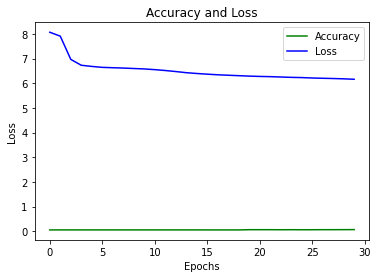

In [39]:
accuracy_val = history.history['val_accuracy']
loss = history.history['loss']
epochs = range(0,num_epochs)
plt.plot(epochs, accuracy_val, 'g', label='Accuracy')
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<a id="keras_evaluate_rnn"></a>
### Evaluating the neural network

In [ ]:
# Loading with TF2-DirectML on GPU fails for me
# so use CPU instead
with device('/cpu:0'):
    model = load_model(os.path.join(model_dir, model_file))

model.summary()
model.evaluate(X_valid, y_valid, batch_size=4096, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         5518000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 27590)             3559110   
Total params: 9,262,070
Trainable params: 9,262,070
Non-trainable params: 0
_________________________________________________________________


<a id="keras_predict_rnn"></a>
### Making Predictions

In [ ]:
from tensorflow.errors import UnimplementedError
import warnings, time

# Suppress log divde by 0 error
# which can occur sometimes 
warnings.filterwarnings('ignore')

In [ ]:
# Load tokenizer
model_name = "model-baseline"
with open(os.path.join(tokenizer_dir, model_name + ".pkl"), "wb") as f:
    tokenizer = pickle.load(f)

In [ ]:
# Randomness factor (in range [0, 1]
# 1.0 means no randomness
rand = 0.9

# Timeout for prediction in seconds
timeout = 2

# Fallback prediction length
# in case end of sentence is not predicted in time
pred_len = 10

# Get input sequence
s = [input("Enter a sentence to complete: ")]
sequences = np.array(tokenizer.texts_to_sequences(s))
len_orig = len(sequences)

# Make prediction
predictions = []
elem = ""
t_start = time.time()

# Stop on punctuation
end_symbols = ['.', '?', '!']
end_tokens = []
for t in end_symbols:
    try:
        t = tokenizer.word_index[t]
        end_tokens.append(t)
    except KeyError:
        continue

while elem not in end_tokens:
    try:
        pred = model.predict(sequences)[0]
    except UnimplementedError:
        log.warning("Input contains words that are not in vocabulary. Prediction will be inaccurate.")
    
    # Introduce random factor to prevent getting
    # stuck in prediction loop
    pred = np.exp(np.log(pred) / rand)
    
    # Issue: https://github.com/numpy/numpy/issues/8317
    # Solution: https://stackoverflow.com/a/53605818
    pred = np.asarray(pred).astype('float64')
    
    # Softmax
    pred = pred / pred.sum()
    
    # Pick one word from the
    # generated probability distribution
    probs = np.random.multinomial(1, pred, 1)[0]
    elem = np.argmax(probs)
    
    # Separately save predictions
    predictions.append(elem)
    
    # Append to current sequence for new input
    sequences = np.append(sequences, [[elem]], axis=1)
    
    # Timeout and fallback
    elapsed = time.time() - t_start
    if elapsed >= timeout:
        log.warning(f"Could not predict end of sentence within {timeout}s. Falling back to predicting {pred_len} words.")
        sequences = sequences[:len_orig + pred_len]
        predictions = predictions[:pred_len]
        break

# Convert model output to human-readable text
predictions = tokenizer.sequences_to_texts([predictions])[0]

log.info(f"Predicted sequence:\n{''.join(s[0])}\n{''.join(predictions)}")

Enter a sentence to complete: Our algorithm had a


[INFO] Main: Predicted sequence:
Our algorithm had a
cluster , clustering a set of genetic heterogeneity .
